In [1]:
import kaggle
import pandas
import os
import re
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings

from torchvision.models import efficientnet_b0
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np

from model.model import efficient_net_b0
from misc.train import train_model, test_model
from misc.plotting import get_examples
from misc.data_preprocessing import CustomImageDataset, get_statistics, download_data, create_dataloaders, get_dataloader_example


In [2]:
path = './data/'
download_data(path)

/Users/benbradshaw/Documents/Code/2023/dogs_vs_cats_2/misc/data_preprocessing.py:89: UserWarning: Directory already exists. Download skipped, but the code continues!
  warnings.warn(


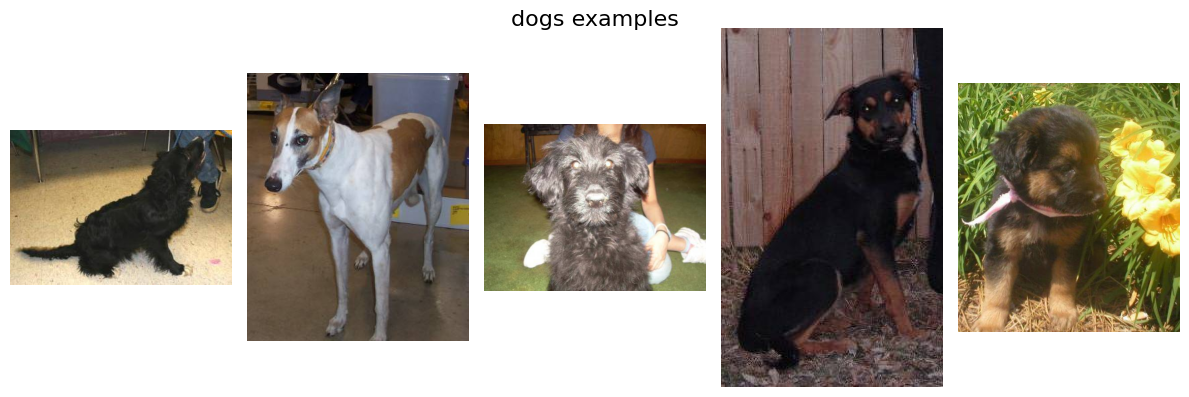

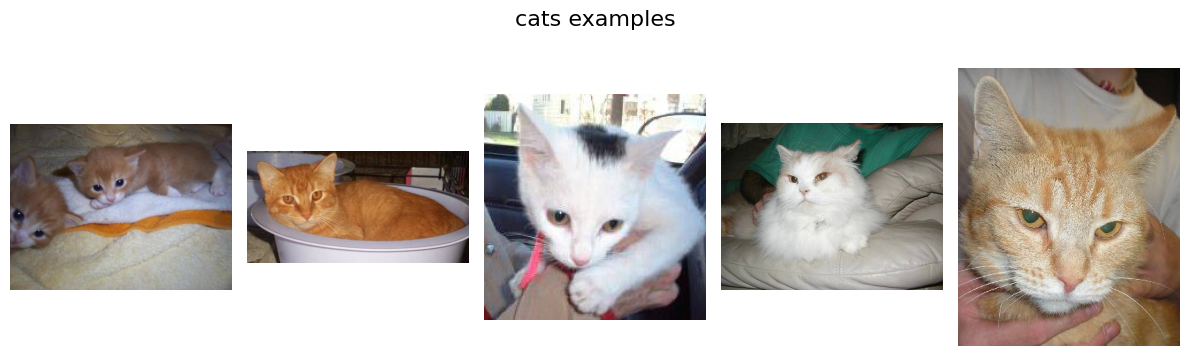

In [3]:
get_examples(5)

In [4]:
# Train Statistics
get_statistics('./data/training_set/training_set/')

# Test Statistics
get_statistics('./data/test_set/test_set/')

Number of dogs: 4005
Most common dogs image shapes:
width: 500, height: 374, count: 450
width: 499, height: 375, count: 423
width: 375, height: 499, count: 45

Number of cats: 4000
Most common cats image shapes:
width: 499, height: 375, count: 506
width: 500, height: 374, count: 490
width: 499, height: 333, count: 48

Directory not found for .DS_Store: ./data/training_set/training_set/.DS_Store/
Number of dogs: 4005
Most common dogs image shapes:
width: 500, height: 374, count: 450
width: 499, height: 375, count: 423
width: 375, height: 499, count: 45

Number of cats: 4000
Most common cats image shapes:
width: 499, height: 375, count: 506
width: 500, height: 374, count: 490
width: 499, height: 333, count: 48

Directory not found for .DS_Store: ./data/training_set/training_set/.DS_Store/


In [5]:
import os
import re
import warnings

import kaggle
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import transforms

def create_dataloaders(train_directory_path:str, test_directory_path:str, batch_size:int=2):
    train_transform = transforms.Compose([
        transforms.Resize((224, 224), interpolation=Image.LANCZOS),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=45),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_and_val_transform = transforms.Compose([
        transforms.Resize((224, 224), interpolation=Image.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = CustomImageDataset(directory_path=train_directory_path, transform=train_transform)
    val_dataset = CustomImageDataset(directory_path=train_directory_path, transform=test_and_val_transform)
    test_dataset = CustomImageDataset(directory_path=test_directory_path, transform=test_and_val_transform)

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size

    train_dataset, _ = random_split(train_dataset, [train_size, val_size])
    _, val_dataset = random_split(val_dataset, [train_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True, num_workers=1)
    val_loader = DataLoader(dataset=val_dataset, batch_size=2, shuffle=False, num_workers=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=2, shuffle=False, num_workers=1)
    
    return train_loader, val_loader, test_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Images Shape: torch.Size([2, 3, 224, 224])
Labels Shape: torch.Size([2, 2])
Example Image:


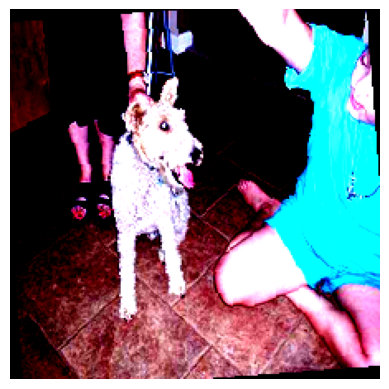

Image Class: tensor([1., 0.])


In [6]:
train_loader, val_loader, test_loader = create_dataloaders(
	train_directory_path="./data/training_set/training_set/", 
	test_directory_path="./data/test_set/test_set/", 
	batch_size=2
)

get_dataloader_example(train_loader)

In [7]:
# Our efficient net model
model = efficient_net_b0()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f'Total number of parameters in our EfficientNet-B0: {total_params}')
 
# Built in pytorch efficient net model
model = efficientnet_b0(num_classes=2, pretrained=False)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f'Total number of parameters in official EfficientNet-B0: {total_params}')

Total number of parameters in our EfficientNet-B0: 4339424
Total number of parameters in official EfficientNet-B0: 4010110


/Users/benbradshaw/Documents/Code/2023/dogs_vs_cats_2/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/benbradshaw/Documents/Code/2023/dogs_vs_cats_2/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = efficient_net_b0()
model = model.to(device)

model_path = './model/model_weights.pth'
if os.path.isfile(model_path):
	model.load_state_dict(torch.load(model_path)) 
	print('Model weights loaded from :', model_path)
else:
	print('No model weights were loaded')


optimizer = torch.optim.Adam(
	params=model.parameters(),
	lr=1e-4
)

scheduler = ReduceLROnPlateau(
	optimizer,
	'min',
	factor=0.1,
	min_lr=1e-6
)

No model weights were loaded


In [ ]:
train_model(
	model,
	optimizer,
	scheduler=scheduler,
	train_loader=train_loader,
	val_loader=val_loader,
	model_path=model_path,
	epochs=200,
	patience=25,
	threshold=1e-4
)

In [9]:
#model.load_state_dict(torch.load(model_path))

test_model(model, test_loader)

/Users/benbradshaw/Documents/Code/2023/dogs_vs_cats_2/myenv/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


KeyboardInterrupt: 

In [ ]:
!pip install zipfile

import zipfile

# Path to your zip file
zip_file_path = 'dogs_vs_cats_2.zip'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('dogs_vs_cats_2')  # Specify the extraction path